## PyMC GeoMod Sandstone Simplified

#### Importing stuff

In [1]:
%matplotlib inline
from IPython.core.display import Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import shutil
#import geobayes_simple as gs

import pymc as pm # PyMC 2
from pymc.Matplot import plot
from pymc import graph as gr
import pandas as pn
import numpy as np
#import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# as we have our model and pygeomod in different paths, let's change the pygeomod path to the default path.
sys.path.append("C:\Users\Miguel\workspace\pygeomod\pygeomod")
#sys.path.append(r'/home/jni/git/tmp/pygeomod_tmp')
import geogrid
import geomodeller_xml_obj as gxml
reload(gxml)


<module 'geomodeller_xml_obj' from 'C:\Users\Miguel\workspace\pygeomod\pygeomod\geomodeller_xml_obj.pyc'>

In [4]:
sandstone0 = r'..\Geomodeller\Sandstone_small\Sandstone_small.xml'
sandstone2 = r'..\Geomodeller\Sandstone_extremely_simpified\Sandstone_extremely_simpified.xml'
sandstone3 = r'..\Geomodeller\Sandstone_ASEG\Sandstone_ASEG.xml'
sandstone4 = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Sandstone_Ruth.xml'
sandstone = r'C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\SanstoneSimple\SanstoneSimple.xml'

In [5]:
try:
    shutil.copytree(r'C:/Users/Miguel/workspace/geobayes/paper_sandstone/models/SanstoneSimple/', 'Temp_Sandstone/')
except WindowsError:
    print "The folder is already created"

The folder is already created


#### Create the pygeomod model importing the GeoModeller model (last time I used model promised...)

Info about this step: pygeomod notebooks.

In [10]:
sandstone = 'Temp_Sandstone/SanstoneSimple.xml'
print sandstone 

Temp_Sandstone/SanstoneSimple.xml


In [11]:
reload(geogrid)
G1 = geogrid.GeoGrid()

# Using G1, we can read the dimensions of our Murci geomodel
G1.get_dimensions_from_geomodeller_xml_project(sandstone)

G1.set_dimensions(dim=(696094,746777,6866608,6920075,-9272,1000))

nx = 80
ny = 80
nz = 80

print "number of voxels", nx*ny*nz

G1.define_regular_grid(nx,ny,nz)

G1.update_from_geomodeller_project(sandstone)

number of voxels 512000


2
3
696094 746777 6866608 6920075 -9272 1000
[696094 706230 716367 726503 736640 746777]
[    0 10693 21386 32080 42773 53467]


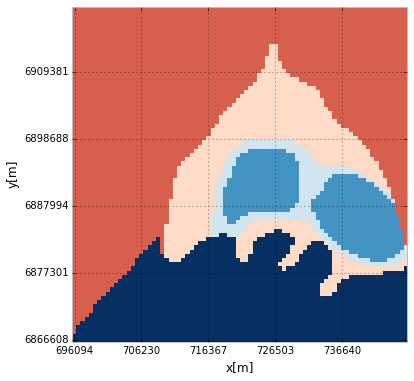

In [13]:
reload(geogrid)

G1.plot_section('z',cell_pos=70,colorbar = False,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, contour =False,geomod_coord= True)

### Creating the Bayesian Model of the input data!
#### First: Importing the uncertainty data from geolgical observations


In [15]:
data = pn.read_excel("C:\Users\Miguel\workspace\geobayes\paper_sandstone\models\Uncertainties.xlsx")                    
#print data[:,[0,3,6,7]]
data_ar = data.values[:,[0,3,6,7]]
print data_ar[:,1] == "depth"

np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0,2,3]])
#if data["type"].value == "depth":
 #   print pn.get_values(data["mean"])
#print data.iloc[[2],[2]]

[False False  True False False  True False False False False  True False
 False False False False False  True  True  True  True  True False False
 False False False False False False  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False]


array([[u'SM_Seis_C', 5680.0, 500.0],
       [u'SM_Seis_E', 3050.0, 500.0],
       [u'SM_Sand_C', 5010.0, 1.0],
       [u'SM_Atley_1', 4550.0, 1.0],
       [u'SM_Atley_2', 3600.0, 1.0],
       [u'SM_Atley_3', 6000.0, 1.0],
       [u'SM_Atley_4', 3200.0, 1.0],
       [u'SM_Atley_5', 5600.0, 1.0],
       [u'BIF_Atley_2', 1800.0, 1.0],
       [u'BIF_Atley_3', 3900.0, 1.0],
       [u'BIF_Atley_4', 500.0, 1.0],
       [u'BIF_Atley_5', 1800.0, 1.0]], dtype=object)

## Creating out PyMC model our of this


In the first try we are gonna take the surface points as real values since in any case they will have less uncertainty.

In [16]:
# Stochastics
data_depth = np.asarray(data_ar[data_ar[:,1] == "depth"][:,[0, 2,3]])
contact_points = []
for i in range(len(data_depth)):
    contact_points = np.append(contact_points, pm.Normal(str(data_depth[i,0]), data_depth[i,1], 1./np.square(data_depth[i,2])))

print contact_points[0]    
    
data_azimuth = np.asarray(data_ar[data_ar[:,1] == "azimuth"][:,[0, 2,3]])
azimuths = []    
for i in range(len(data_azimuth)):
    azimuths = np.append(azimuths, pm.Normal(str(data_azimuth[i,0]), data_azimuth[i,1], 1./np.square(data_azimuth[i,2])))   

data_dip = np.asarray(data_ar[data_ar[:,1] == "dip"][:,[0, 2,3]])
dips = []
for i in range(len(data_dip)):
    dips = np.append(dips, pm.Normal(str(data_dip[i,0]), data_dip[i,1], 1./np.square(data_dip[i,2])))  

    
    
# First Constrains






# ===============================================================================
# Generation of model
# ===============================================================================
@pm.deterministic
def section(contact_points = contact_points, azimuths = azimuths , dips = dips):
    # Create the array we will use to modify the xml. We have to check the order of the formations
    
    #  print samples
    #print samples
    # Load the xml to be modify
    org_xml = 'Temp_Sandstone/SanstoneSimple.xml'
    
    #Create the instance to modify the xml
        # Loading stuff
    reload(gxml)
    gmod_obj = gxml.GeomodellerClass()
    gmod_obj.load_geomodeller_file(org_xml)
    
    # Create a dictionary so we can acces the section through the name
    section_dict = gmod_obj.create_sections_dict()
    
    # ## Get the points of all formation for a given section: Dictionary
    contact_points_ori = gmod_obj.get_formation_point_data(section_dict['Atley'])
    
    # Check the position of points you want to change
    points_changed = gmod_obj.get_point_coordinates(contact_points_ori)
    print "Points coordinates", points_changed
   # print len(contact_points[:-4])
    
    #Perform the position Change
    for i, point in enumerate(contact_points_ori):
        gmod_obj.change_formation_point_pos(point, y_coord = [2] )#, print_points = True)
    
    # Check the new position of points
              #points_changed = gmod_obj.get_point_coordinates(contact_points)
              #print "Points coordinates", points_changed
    
    # Write the new xml
    gmod_obj.write_xml("Temp_Sandstone/new.xml")
       
    # Read the new xml
    new_xml = 'Temp_Sandstone/new.xml'
    G1 = geogrid.GeoGrid()
    
    # Getting dimensions and definning grid
    
    G1.get_dimensions_from_geomodeller_xml_project(new_xml)
    
    # Resolution!
    nx = 400
    ny = 2
    nz = 400
    G1.define_regular_grid(nx,ny,nz)
    
    # Updating project
    G1.update_from_geomodeller_project(new_xml)
   # G1.plot_section('y',cell_pos=1,colorbar = True,  cmap='RdBu', figsize=(6,6),interpolation= 'nearest' ,ve = 1, geomod_coord= True, contour = True)
    #print "I am here"
    return G1






# Second Constrains







# Inversion

pymc_model = pm.Model(contact_points, azimuths, dips)

SM_Seis_C
Points coordinates ['SimpleMafic 40808.023,-5589.549 ', 'SimpleMafic 36774.809,-3265.211 ', 'SimpleMafic 31214.105,-6075.459 ', 'SimpleMafic 22125.637,-3623.967 ', 'SimpleMafic 18358.709,-4520.852 ', 'SimpleBIF 31343.773,-3892.5 ', 'SimpleBIF 22242.744,-1856.740 ', 'SimpleBIF 36612.789,-659.238 ', 'SimpleBIF 41821.934,-1796.863 ']
SimpleMafic


TypeError: float() argument must be a string or a number

In [329]:
M = pm.MCMC(pymc_model)
M.sample(iter=2000)

 [-----------------100%-----------------] 2000 of 2000 complete in 2.0 sec

Plotting SM_Sand_Ori_C_a
Plotting SM_Sand_Ori_E_a
Plotting SM_Atley_Ori_C_a
Plotting SM_Atley_Ori_C
Plotting SM_Sand_C
Plotting BIF_Atley_Ori_W_a
Plotting SM_Seis_Ori_W_a
Plotting BIF_Atley_2
Plotting SM_Seis_Ori_C_d
Plotting SM_Seis_C
Plotting SM_Sand_Ori_W_a
Plotting BIF_Atley_Ori_E_d
Plotting SM_Sand_Ori_E_d
Plotting BIF_Atley_Ori_W_d
Plotting SM_Seis_Ori_E_d
Plotting SM_Atley_5
Plotting SM_Atley_3
Plotting SM_Atley_4
Plotting BIF_Atley_4
Plotting SM_Atley_Ori_W_a
Plotting SM_Atley_Ori_E_a
Plotting SM_Seis_Ori_W_d
Plotting SM_Seis_Ori_E_a
Plotting SM_Atley_1
Plotting SM_Seis_E
Plotting SM_Atley_Ori_E_d
Plotting SM_Sand_Ori_W_d
Plotting BIF_Atley_5
Plotting SM_Sand_Ori_C_d
Plotting BIF_Atley_3
Plotting SM_Atley_Ori_W_d
Plotting SM_Atley_2
Plotting SM_Seis_Ori_C_a
Plotting BIF_Atley_Ori_E_a


C:\Users\Miguel\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


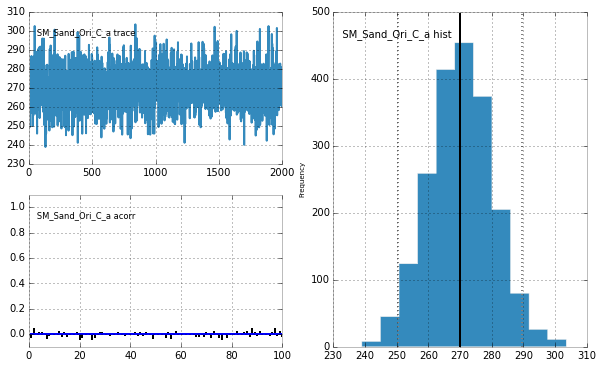

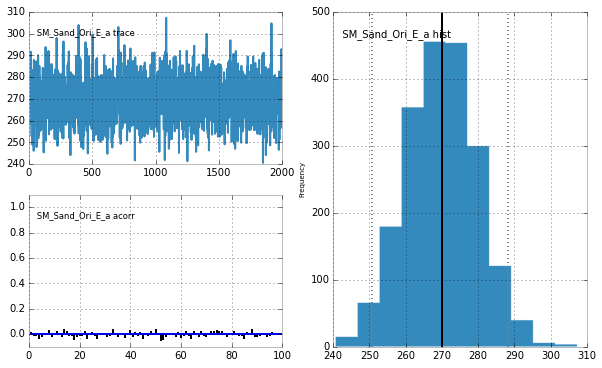

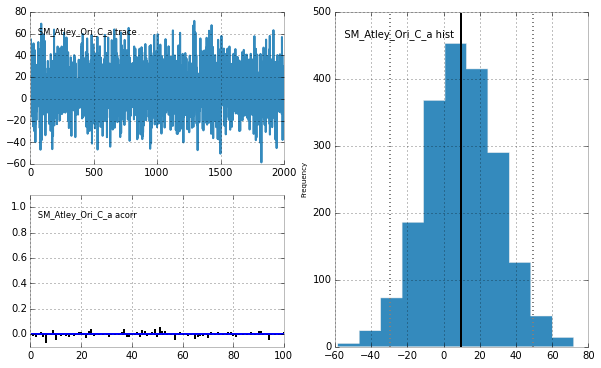

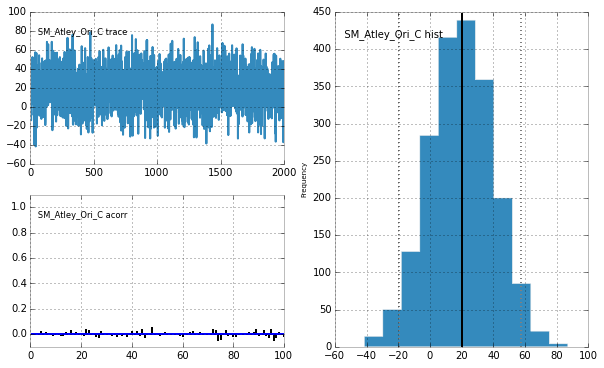

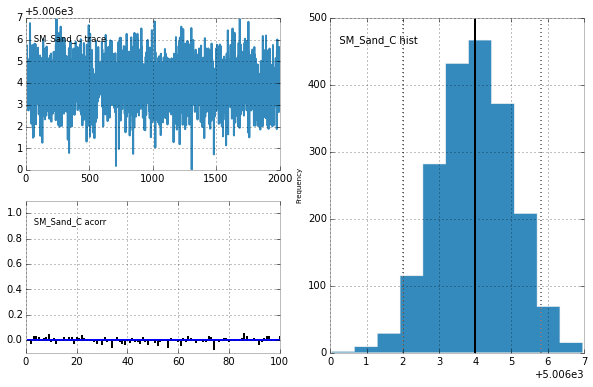

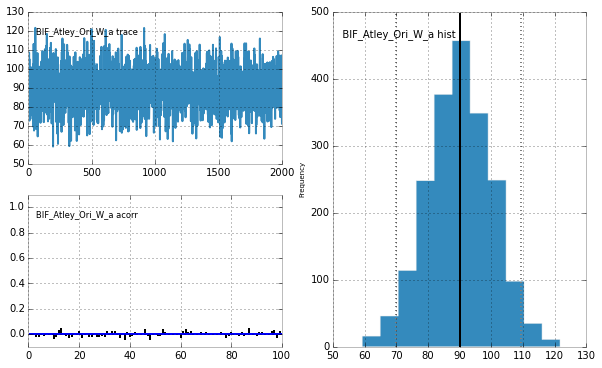

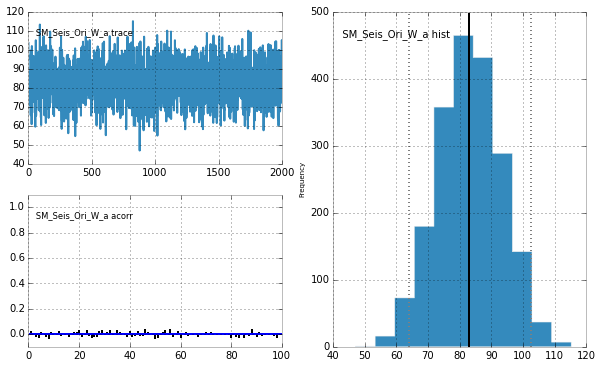

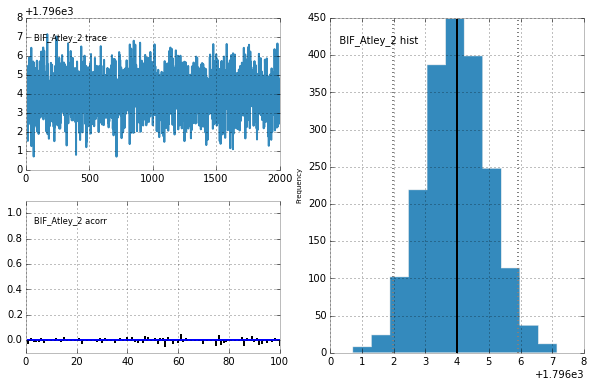

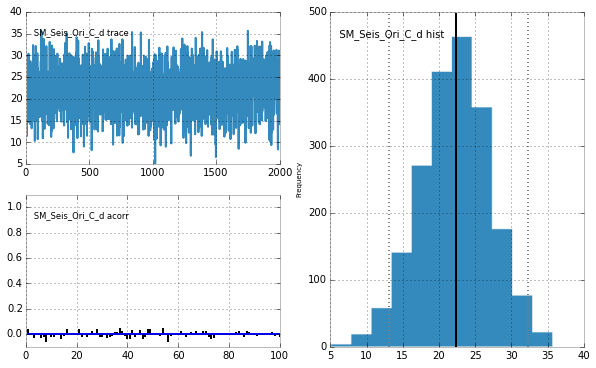

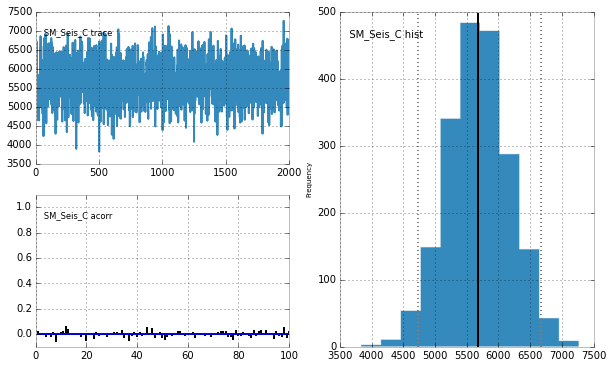

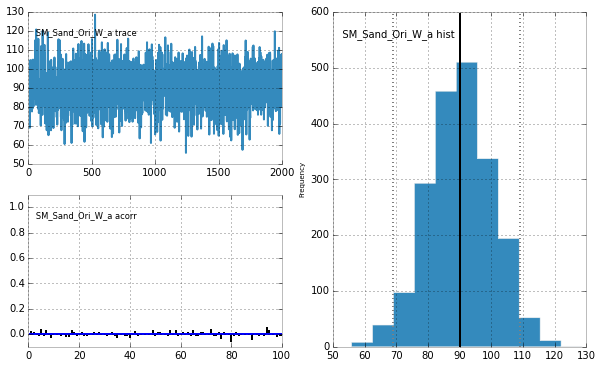

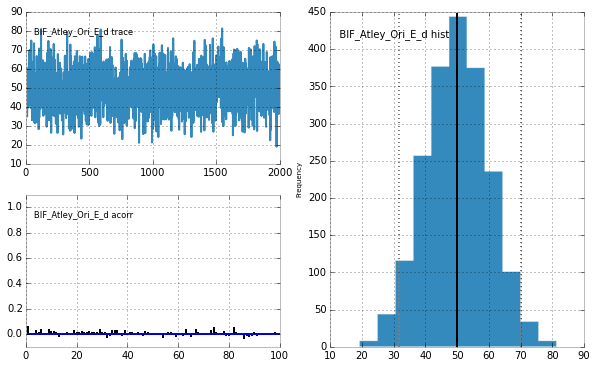

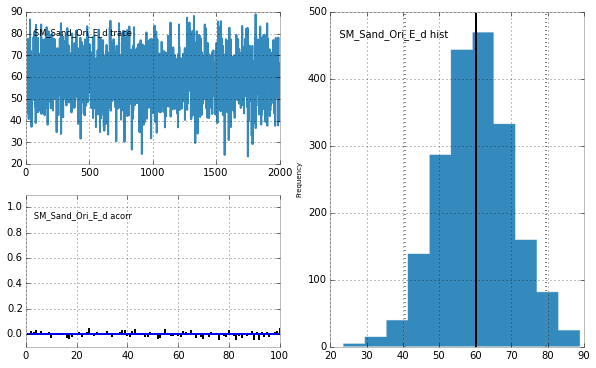

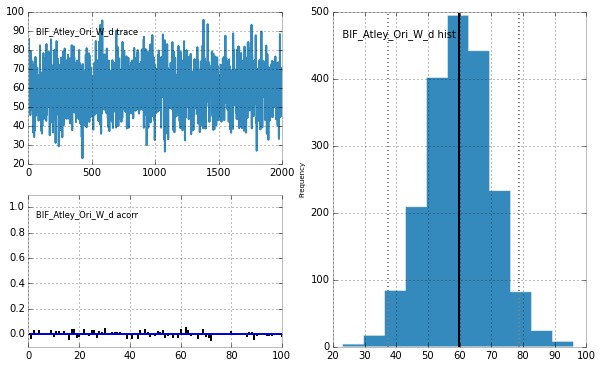

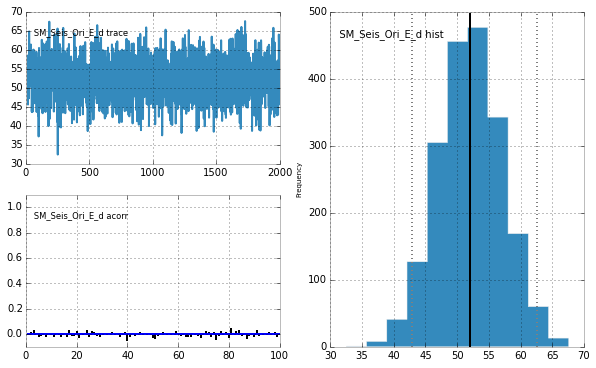

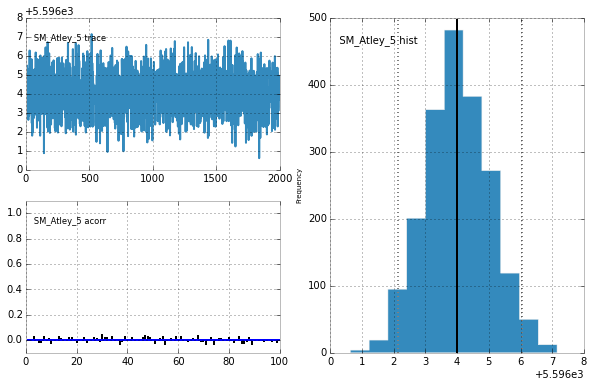

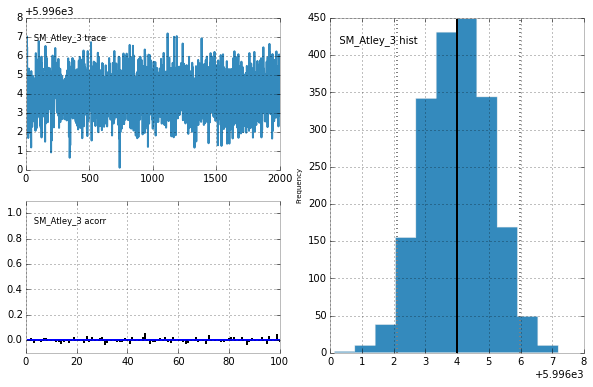

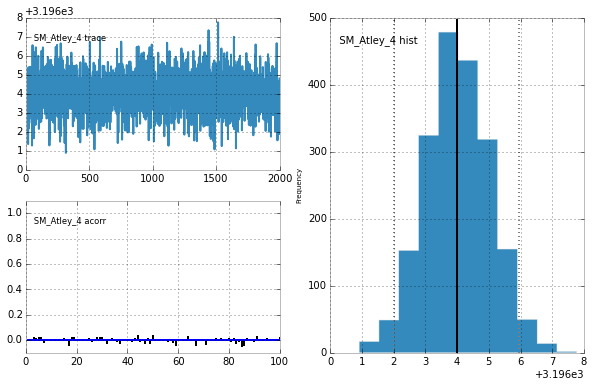

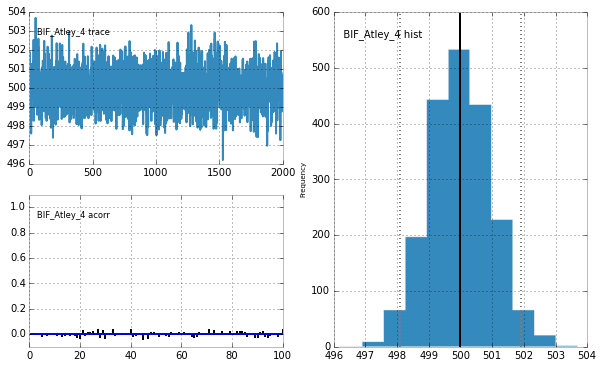

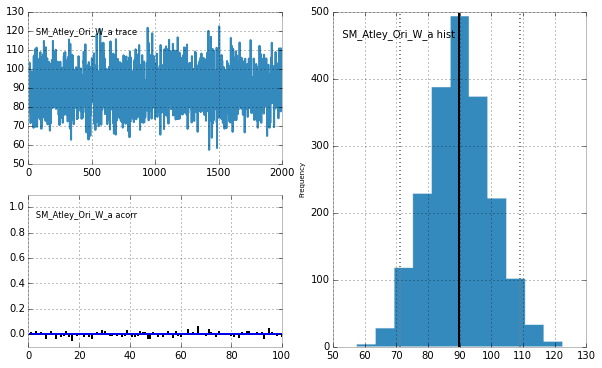

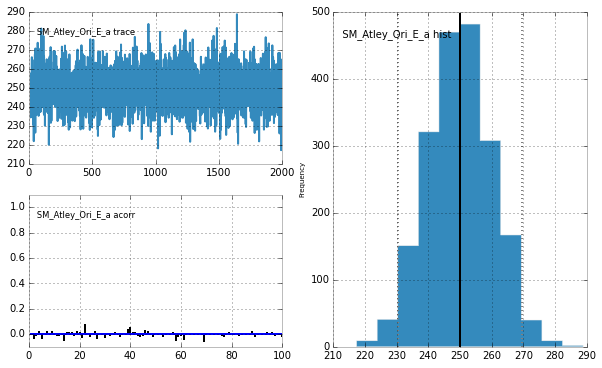

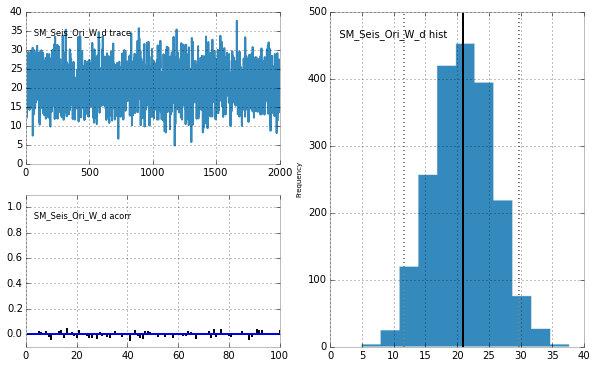

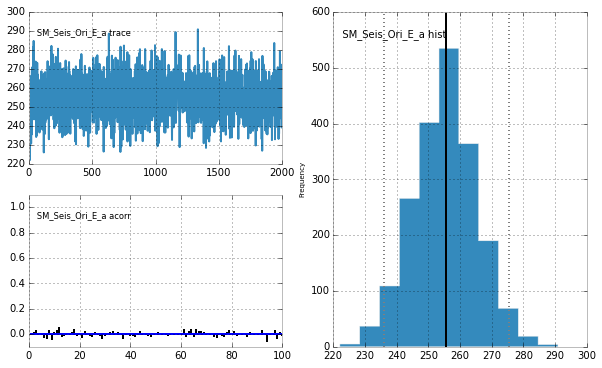

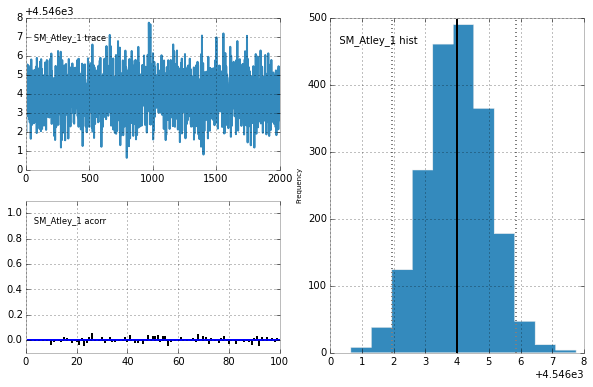

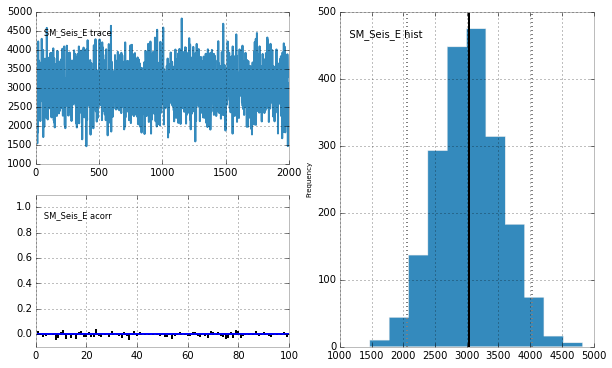

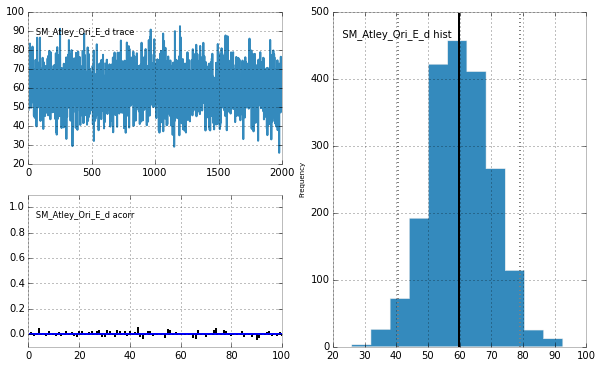

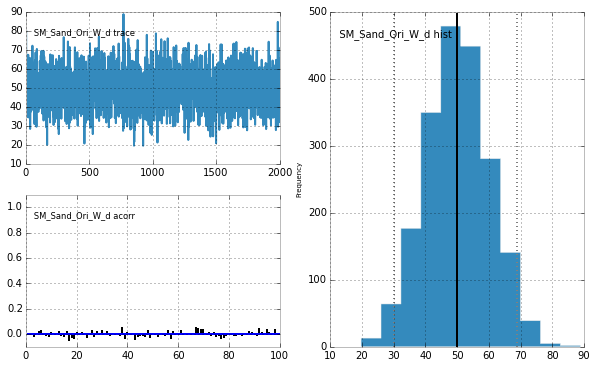

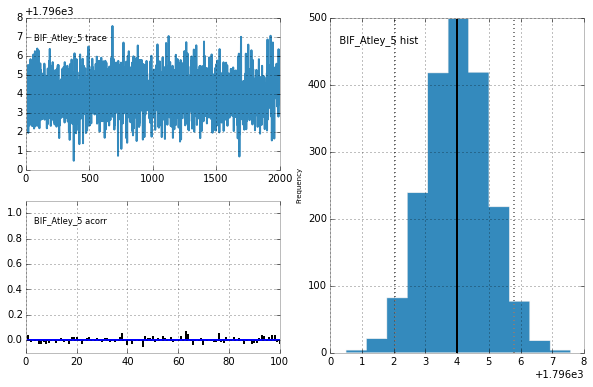

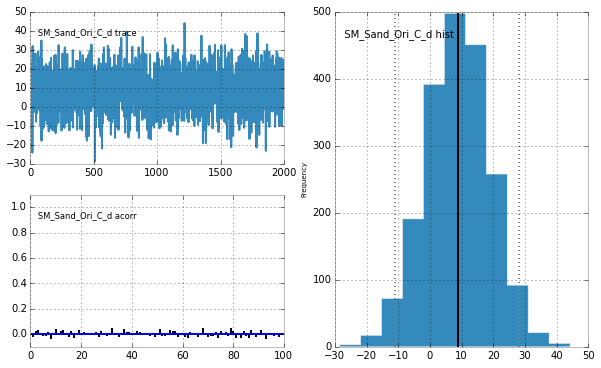

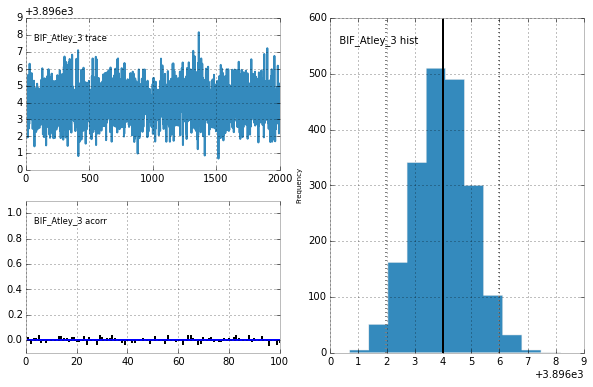

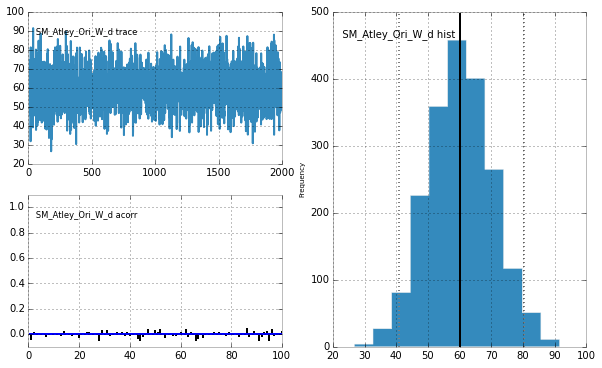

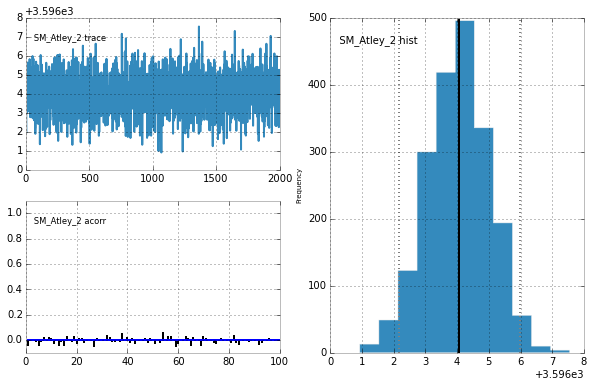

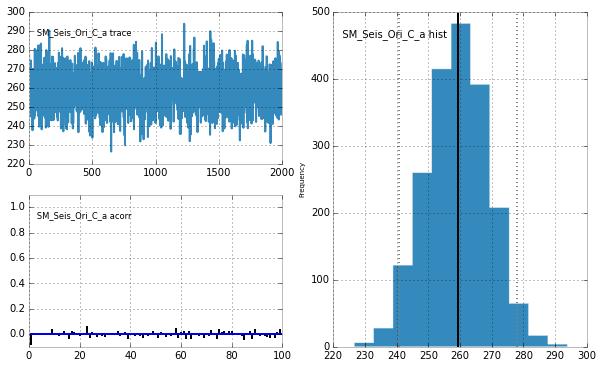

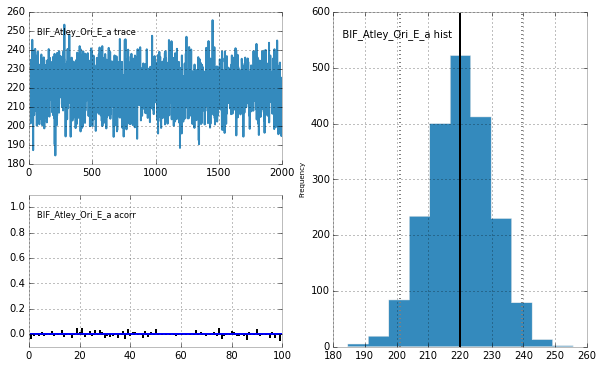

In [330]:
plot(M)

In [331]:
a = gr.dag(M)
a.write_png("Sandstone.png")

True

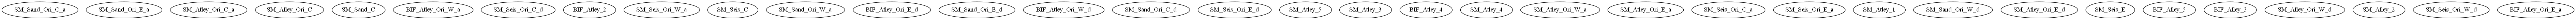

In [333]:
Image("Sandstone.png")

In [52]:
reload(gxml)
gmod_obj = gxml.GeomodellerClass()
gmod_obj.load_geomodeller_file(sandstone)


In [53]:
# Section names:
section_names = gmod_obj.get_section_names()
print "section names",section_names, "\n" 

# Choose the section we want to use with Positon
sections = gmod_obj.get_sections()[0]
print "Chosen section by position", sections, "\n"

# Create a dictionary so we can acces the section through the name
section_dict = gmod_obj.create_sections_dict()
print "Chosen section by entry", section_dict["Seismic"][1], "\n"



# Formation names
formation_names = gmod_obj.get_formation_names()
print "formation names", formation_names, "\n"

# Get the points of all formation for a given section: Position
#contact_points = gmod_obj.get_formation_point_data(sections) #to extract points you have to choose one of the sections
#print "Contact points on the chosen section", contact_points, "\n", type(contact_points)

## Get the points of all formation for a given section: Dictionary
contact_points = gmod_obj.get_formation_point_data(section_dict['Atley']) #to extract points you have to choose one of the sections
print "Contact points on the chosen section", contact_points, "\n", type(contact_points)

# Showing contact points
points = gmod_obj.get_point_coordinates(contact_points)
print "Points coordinates\n", points, np.shape(points), "\n"

# Foliations

foliations = gmod_obj.get_foliations(section_dict['Atley'])
print "foliations" , foliations,  "\n\n\n"
for i in range(len(foliations)): print "azimut:",gmod_obj.get_foliation_azimuth(foliations[i]), "dip",gmod_obj.get_foliation_dip(foliations[i]), "coordinates", gmod_obj.get_foliation_coordinates(foliations[i])  


section names ['Atley', 'NorthSandstone', 'Seismic', 'SurfaceTopography'] 

Chosen section by position <Element '{http://www.geomodeller.com/geo}Section' at 0x32db2cf8> 

Chosen section by entry <Element '{http://www.geomodeller.com/geo}Structural2DData' at 0x3315a470> 

formation names ['EarlyGranite', 'Murchison', 'SimpleBIF', 'SimpleMafic', 'SimpleMafic2'] 

Contact points on the chosen section [<Element '{http://www.geomodeller.com/geo}Interface' at 0x327fbba8>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x327fbcc0>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x327fbdd8>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x327fbef0>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x329bc128>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x3280b0f0>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x3280b208>, <Element '{http://www.geomodeller.com/geo}Interface' at 0x3280b320>, <Element '{http://www.geomodeller.com/geo}Inte